# Głębokie sieci neuronowe - rozpoznawanie figur szachowych na obrazach


**Realizowany projekt ma za zadanie rozpoznawac figury szachowe na obrazach przypisując je do jednej z 6 klas. Poniżej przedstawiono przyjęte podejście do rozwiązania podanego problemu z rozwiązaniem prostej architektury Kereas Sequential.**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Sciezka do katalogu z obrazami do predykcji
data_dir = pathlib.Path("/kaggle/input/chessman-image-dataset/Chessman-image-dataset/Chess")

In [ ]:
#Parametryzacja
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#Dane treningowe
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
#Dane walidacyjne
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
#Wizualizacja poczatkowych danych ze zbioru treningowego
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
#Ladowanie oraz normalizacja danych
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [38]:
#Stworzenie modelu
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [39]:
#Kompilacja
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
#Trening
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 7s 442ms/step - loss: 1.9311 - accuracy: 0.1900 - val_loss: 1.7860 - val_accuracy: 0.2000
Epoch 2/10
14/14 [==============================] - 5s 381ms/step - loss: 1.7298 - accuracy: 0.2624 - val_loss: 1.7630 - val_accuracy: 0.2636
Epoch 3/10
14/14 [==============================] - 5s 388ms/step - loss: 1.5563 - accuracy: 0.3914 - val_loss: 1.7349 - val_accuracy: 0.2909
Epoch 4/10
14/14 [==============================] - 5s 383ms/step - loss: 1.3041 - accuracy: 0.5023 - val_loss: 1.7828 - val_accuracy: 0.3727
Epoch 5/10
14/14 [==============================] - 6s 399ms/step - loss: 0.9829 - accuracy: 0.6380 - val_loss: 1.8435 - val_accuracy: 0.3455
Epoch 6/10
14/14 [==============================] - 5s 387ms/step - loss: 0.7111 - accuracy: 0.7579 - val_loss: 2.2453 - val_accuracy: 0.3545
Epoch 7/10
14/14 [==============================] - 5s 384ms/step - loss: 0.5467 - accuracy: 0.8009 - val_loss: 2.4105 - val_accuracy: 0.3182
Epoch 

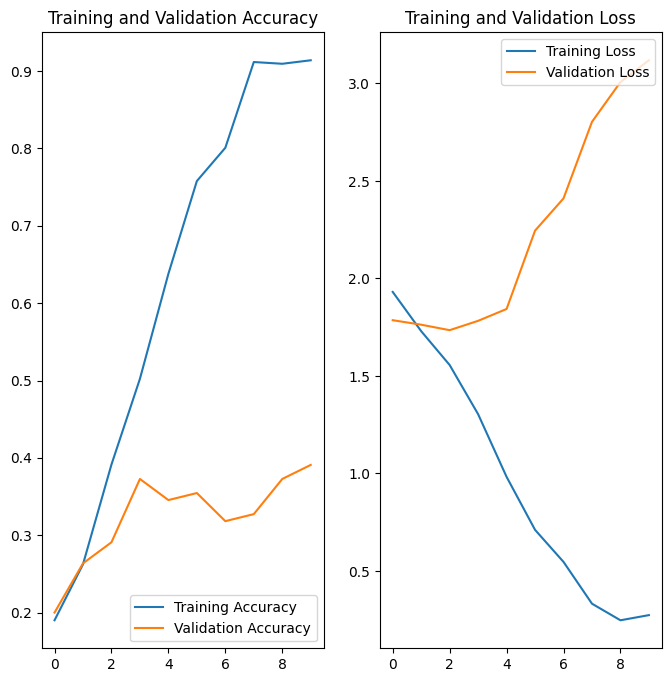

In [41]:
#Wizualizacja wynikow
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
# Naprawienie overfittingu
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

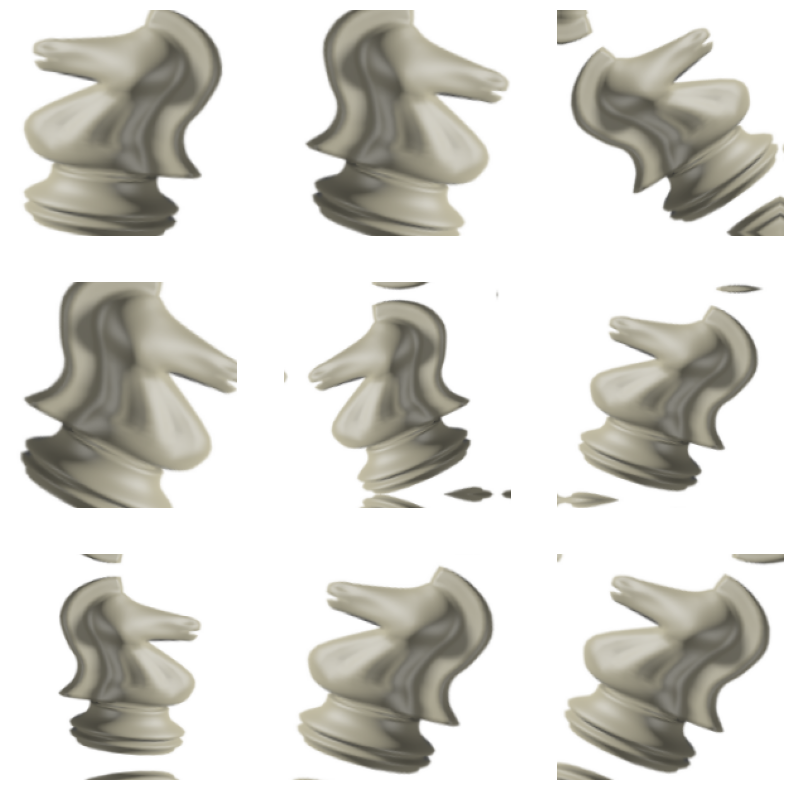

In [107]:
#Sprawdzenie otrzymanych obrazow
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [118]:
#Model z warstwa dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [120]:
#Kompilacja i trening
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
14/14 [==============================] - 7s 422ms/step - loss: 1.3345 - accuracy: 0.4796 - val_loss: 2.0294 - val_accuracy: 0.3545
Epoch 2/100
14/14 [==============================] - 6s 427ms/step - loss: 1.2779 - accuracy: 0.5204 - val_loss: 1.9390 - val_accuracy: 0.3818
Epoch 3/100
14/14 [==============================] - 6s 415ms/step - loss: 1.1968 - accuracy: 0.5362 - val_loss: 1.9749 - val_accuracy: 0.3909
Epoch 4/100
14/14 [==============================] - 6s 414ms/step - loss: 1.1558 - accuracy: 0.5633 - val_loss: 2.0896 - val_accuracy: 0.3636
Epoch 5/100
14/14 [==============================] - 6s 410ms/step - loss: 1.1303 - accuracy: 0.5769 - val_loss: 2.0849 - val_accuracy: 0.3636
Epoch 6/100
14/14 [==============================] - 6s 442ms/step - loss: 1.1270 - accuracy: 0.5814 - val_loss: 2.1979 - val_accuracy: 0.3636
Epoch 7/100
14/14 [==============================] - 6s 412ms/step - loss: 1.0351 - accuracy: 0.6109 - val_loss: 2.3434 - val_accuracy: 0.3455

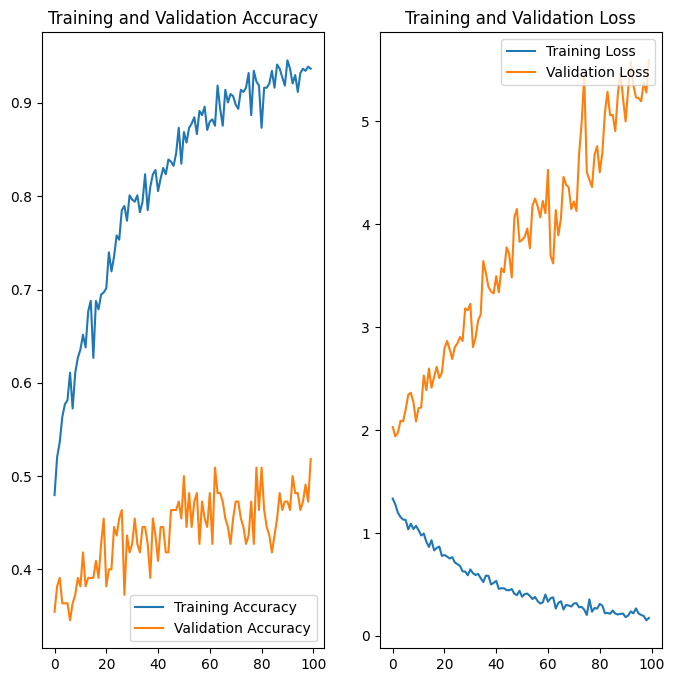

In [121]:
#Wizualizacja wynikow
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()